In [1]:
from utils import *
from probabilistic_models import *

## Loading Datasets

In [2]:
df_1 = pd.read_excel(r"D:\Study\Python\Projects\Paul Project\vendor1.xlsx")
df_2 = pd.read_excel(r"D:\Study\Python\Projects\Paul Project\vendor2.xlsx")

In [3]:
def df_processor(df):
    df_1 = df.sort_values(by="Temperature", ascending=True).reset_index(drop=True)
    df_dict = {temp: df_1[df_1["Temperature"] == temp].reset_index(drop=True) for temp in df_1["Temperature"].unique()}

    df_1['Inverse_Temp'] = 11604.53 / (df_1['Temperature'] + 273.16)  # Convert to Kelvin
    df_1['Ln_Mpa'] = np.log(df_1['Mpa'])  # Log transformation

    return df_1, df_dict

In [4]:
data = pd.concat([df_1, df_2], ignore_index=True)
df,df_dict = df_processor(data)

In [5]:
X_values = df['Inverse_Temp'].values
Y_values = df['Mpa'].values

## Plot Utils

In [7]:
def plot_different_cdf(model,cdf=[0.5,0.9,0.1,0.99,0.01]):
    temperature_values = np.linspace(10, 600, 100)
    fig, ax = plt.subplots(figsize=(8,6))

    ax.scatter(df_1["Temperature"], df_1["Mpa"], edgecolors='black', alpha=0.7, s=30, label=f"Vendor 1")
    ax.scatter(df_2["Temperature"], df_2["Mpa"], edgecolors='black', alpha=0.7, s=30, label=f"Vendor 2")

    for i in range(len(cdf)):
        ys_predicted_cdf = model.predict(cdf[i],temperature_values)
        ax.plot(temperature_values, ys_predicted_cdf, linestyle="-", linewidth=1, label=f"Predicted YS (CDF={cdf[i]})")


    ax.set_xlabel("Temperature (°C)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Yield Stress (YS)", fontsize=12, fontweight="bold")
    ax.set_title("Yield Stress vs. Temperature Comparison", fontsize=14, fontweight="bold")
    ax.legend()
    fig.show()

In [8]:
def line_fit_plot(model):
    plt.figure(figsize=(10, 6))

    for temp in df_dict.keys():
        data = df_dict[temp]["Mpa"].values
        data = np.sort(data)

        try:
            sigma_values, ln_sigma_values,sigma_fit_log, y_fit = model.transform(data)
        except:
            sigma_values, ln_sigma_values,sigma_fit_log, y_fit = model.transform(data, temp)

        plt.scatter(sigma_values, ln_sigma_values, label=f"Temp {temp}")
        plt.plot(sigma_fit_log, y_fit, linestyle='-')

    plt.title(f" {model.name} Probability Plot with Fitted Line", fontsize=14, fontweight="bold")
    plt.xlabel("ln(Data)", fontsize=12)
    plt.ylabel("Standard Normal Quantile", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

## Weibull Model

In [9]:
weibull = WeibullModel(X_values, Y_values)
weibull.intercept,weibull.slope, weibull.shape

print(f"Shape: {weibull.shape:.4f}") 
print(f"Intercept (k): {weibull.intercept:.4f}")
print(f"Slope (m): {weibull.slope:.4f}")

Shape: 25.7553
Intercept (k): 5.8976
Slope (m): 0.0233


C:\Users\mohit\AppData\Local\Temp\ipykernel_13300\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


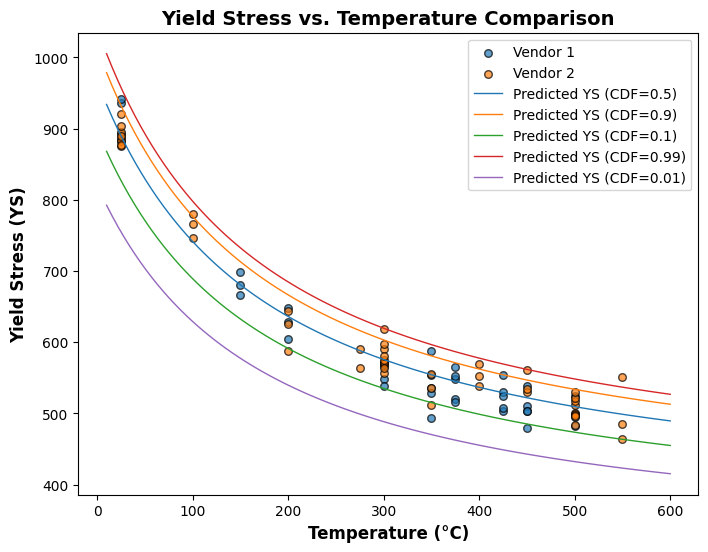

In [10]:
plot_different_cdf(weibull)

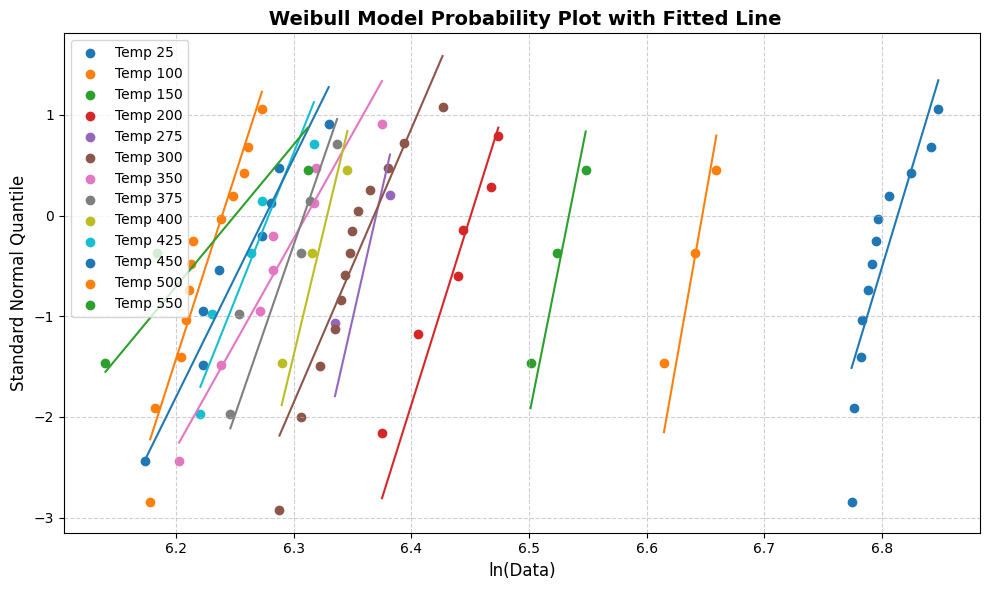

In [11]:
line_fit_plot(weibull)

## LogNormal Model

In [12]:
lognormal = LognormalModel(X_values, Y_values)

print(f"Sigma: {lognormal.sigma:.4f}") 
print(f"Intercept (k): {lognormal.k:.4f}")
print(f"Slope (m): {lognormal.m:.4f}")

Sigma: 0.0386
Intercept (k): 5.8598
Slope (m): 0.0242


C:\Users\mohit\AppData\Local\Temp\ipykernel_13300\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


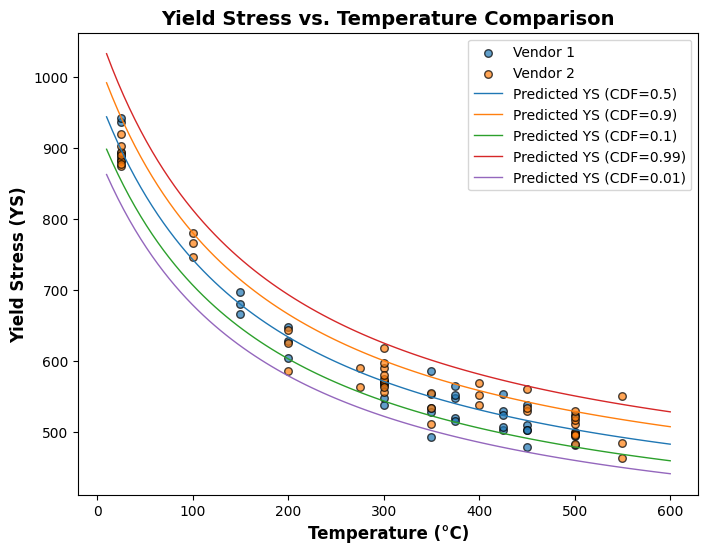

In [13]:
plot_different_cdf(lognormal)

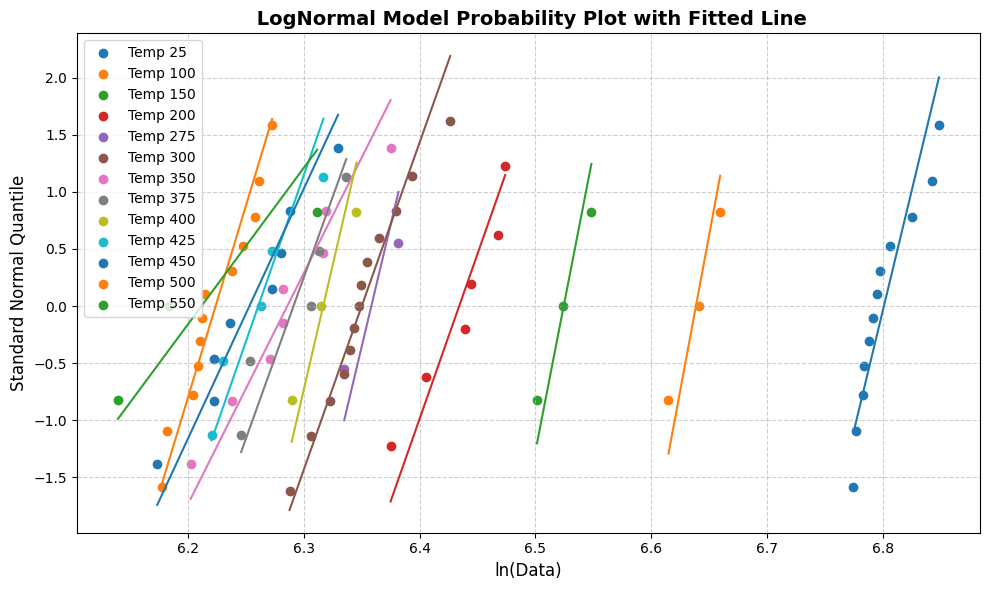

In [14]:
line_fit_plot(lognormal)

## Normal Model:

In [15]:
normal = NormalModel(X_values, Y_values)

print(f"Sigma: {normal.sigma:.4f}") 
print(f"Intercept (k): {normal.intercept:.4f}")
print(f"Slope (m): {normal.slope:.4f}")

Sigma: 24.8563
Intercept (k): 246.9865
Slope (m): 16.4714


C:\Users\mohit\AppData\Local\Temp\ipykernel_13300\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


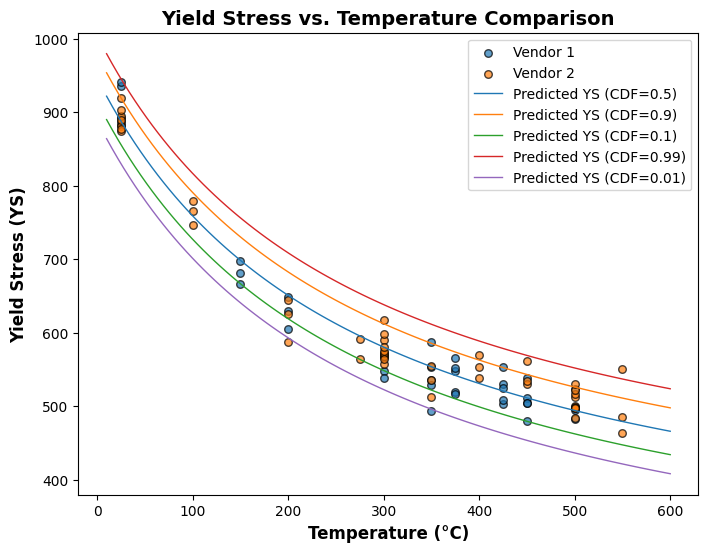

In [16]:
plot_different_cdf(normal)

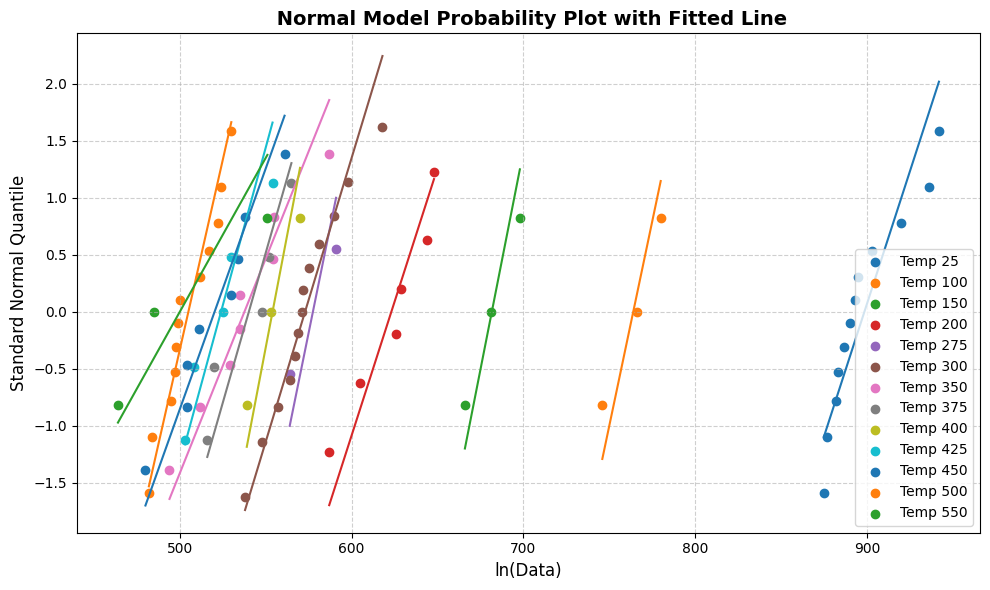

In [17]:
line_fit_plot(normal)

## Weibull (3-Parameters):

In [18]:
wb3 = WeibullModel3(X_values, Y_values)

print(f"Shape: {wb3.shape:.4f}") 
print(f"Delta: {wb3.delta:.4f}") 
print(f"Intercept (k): {wb3.intercept:.4f}")
print(f"Slope (m): {wb3.slope:.4f}")

Shape: 23.4686
Delta: 53.4825
Intercept (k): 5.7600
Slope (m): 0.0253


C:\Users\mohit\AppData\Local\Temp\ipykernel_13300\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


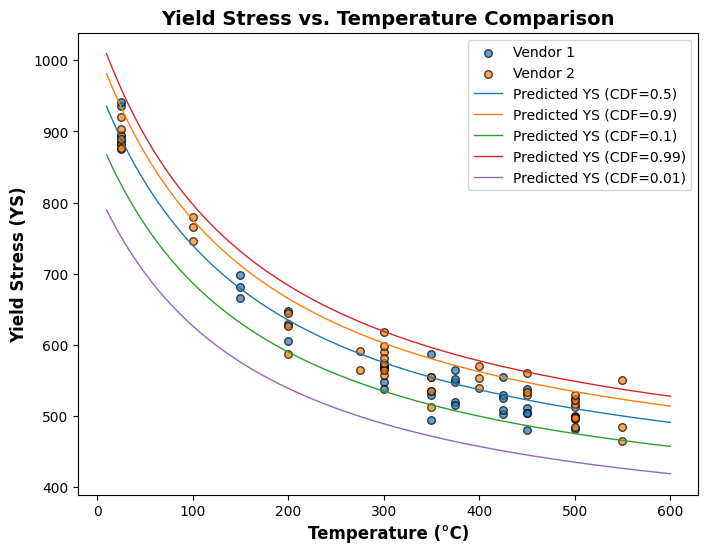

In [19]:
plot_different_cdf(wb3)

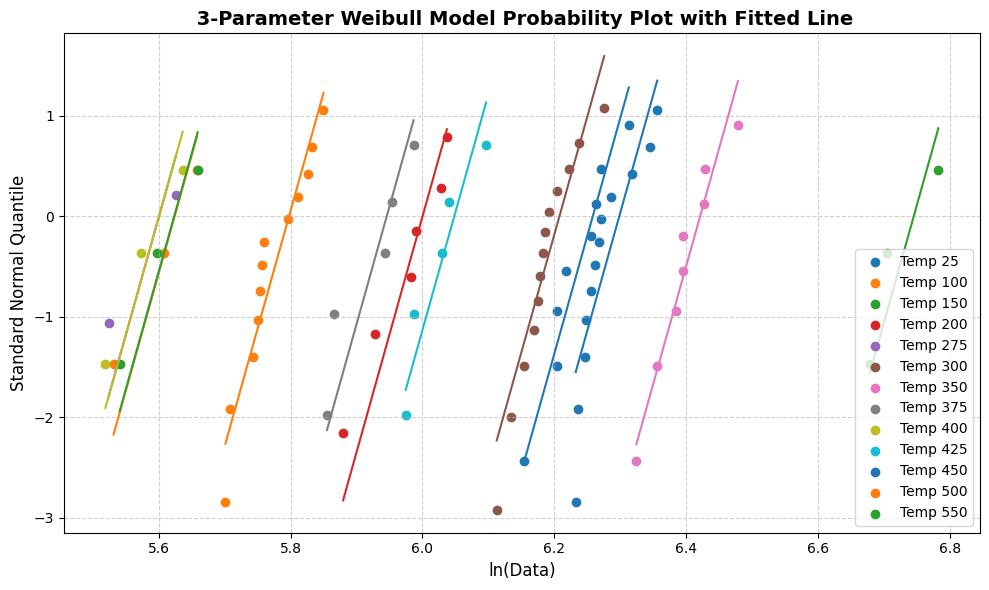

In [20]:
line_fit_plot(wb3)

## LogNormal3

In [21]:
lnm = LognormalModel3(X_values,Y_values)

print(f"Intercept (k): {lnm.k:.4f}")
print(f"Slope (m): {lnm.m:.4f}")
print(f"sigma: {lnm.sigma:.4f}")
print(f"gamma: {lnm.gamma:.4f}")

Intercept (k): 5.8574
Slope (m): 0.0242
sigma: 0.0387
gamma: 0.9896


C:\Users\mohit\AppData\Local\Temp\ipykernel_13300\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


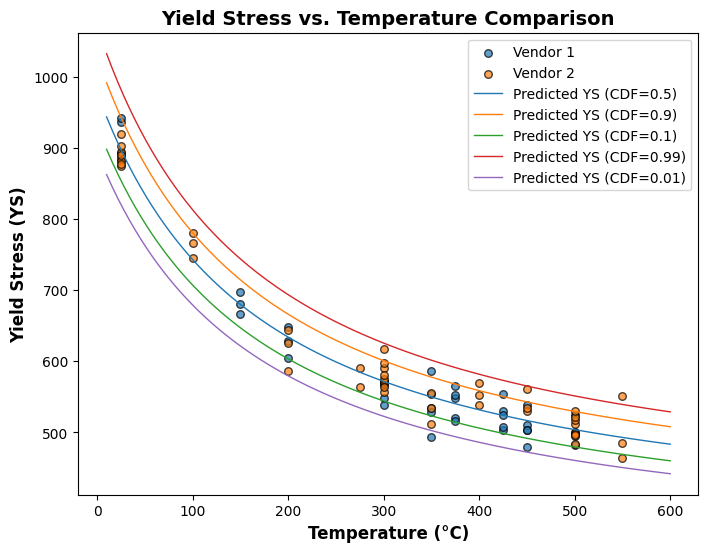

In [22]:
plot_different_cdf(lnm)

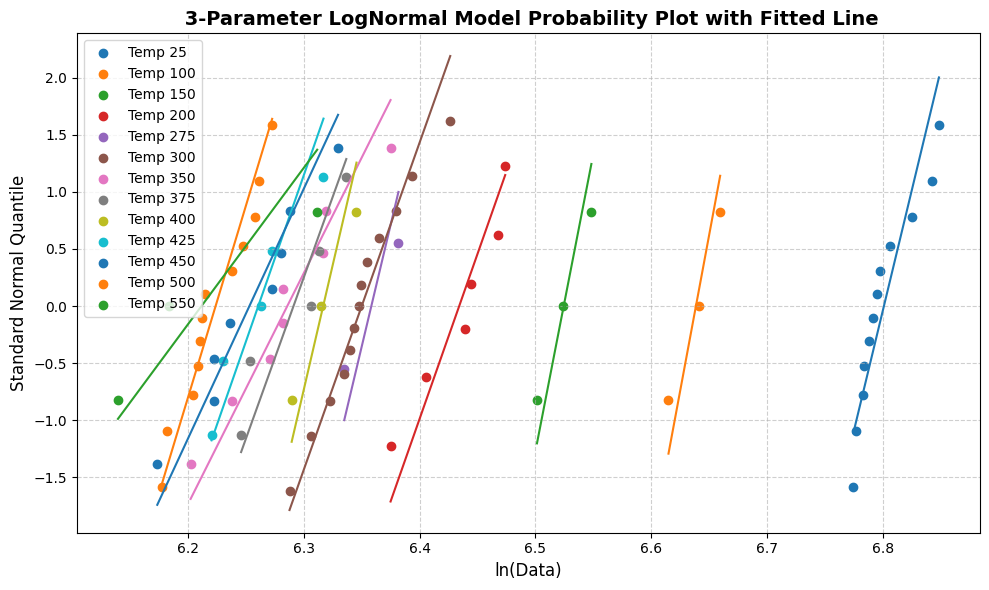

In [23]:
line_fit_plot(lnm)

## Gumbell Model:

In [24]:
gb = Gumbell(X_values, Y_values)

print(f"Intercept (u): {gb.intercept:.4f}")
print(f"Slope (w): {gb.slope:.4f}")
print(f"Gumbel Scale (sigma): {gb.scale:.4f}")

Intercept (u): 369.4465
Slope (w): 10.1489
Gumbel Scale (sigma): 23.9707


C:\Users\mohit\AppData\Local\Temp\ipykernel_13300\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


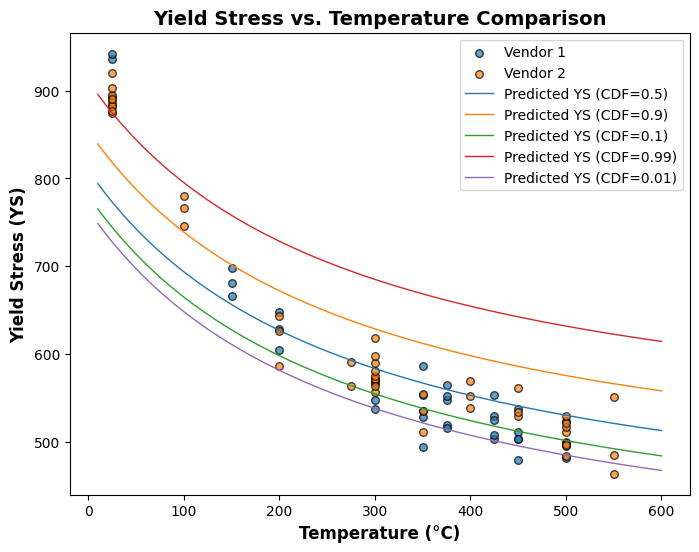

In [25]:
plot_different_cdf(gb)

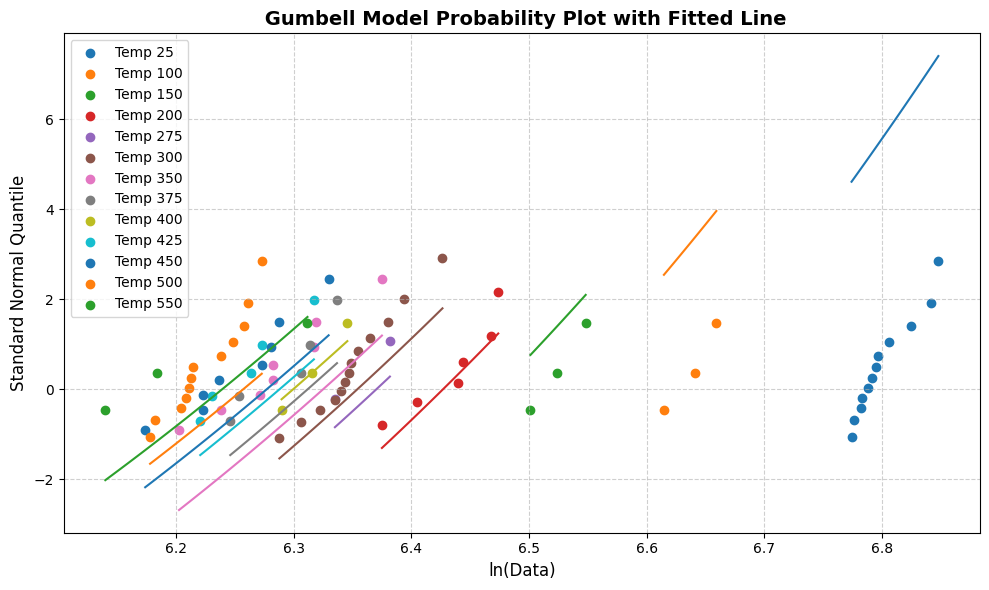

In [26]:
line_fit_plot(gb)

## Exponential:

In [27]:
exp = Exponential(X_values, Y_values)

In [28]:
print(f"Intercept (u): {exp.intercept:.4f}")
print(f"Slope (w): {exp.slope:.4f}")

Intercept (u): 5.8612
Slope (w): 0.0241


C:\Users\mohit\AppData\Local\Temp\ipykernel_13300\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


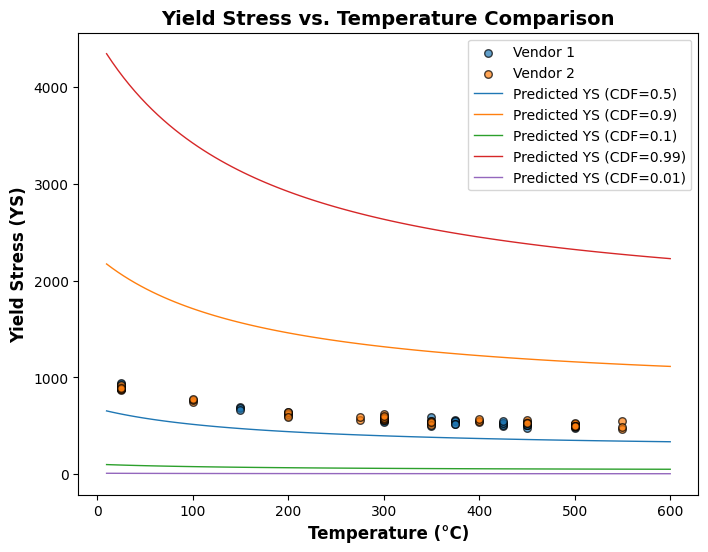

In [29]:
plot_different_cdf(exp)

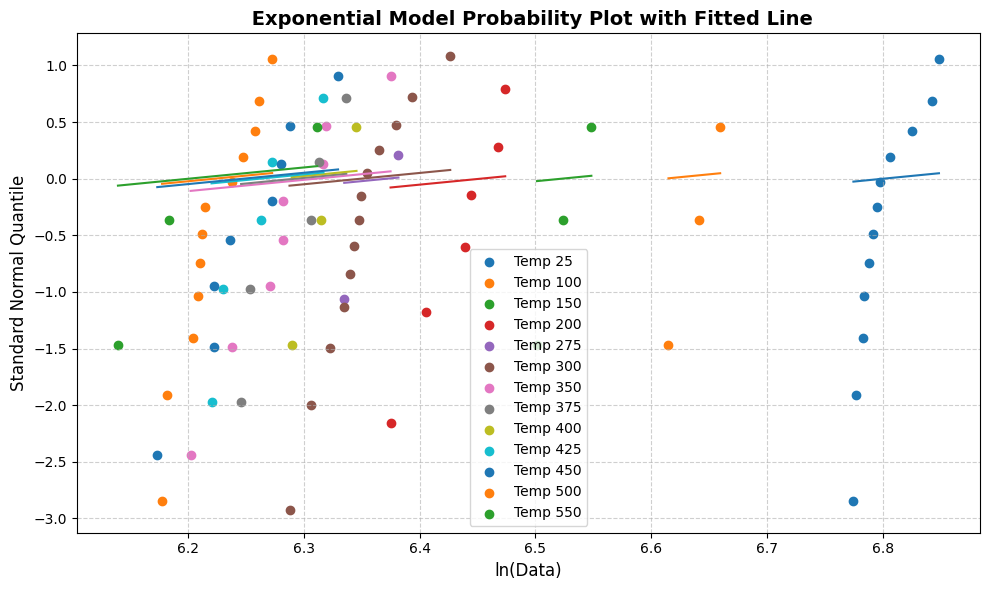

In [30]:
line_fit_plot(exp)

## Gamma

In [31]:
gm = Gamma(X_values, Y_values)

In [32]:
print(f"[Gamma Fit] Shape: {gm.shape:.4f}") 
print(f"Intercept (u): {gm.intercept:.4f}")
print(f"Slope (w): {gm.slope:.4f}")

[Gamma Fit] Shape: 644.4057
Intercept (u): -0.6071
Slope (w): 0.0241


C:\Users\mohit\AppData\Local\Temp\ipykernel_13300\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


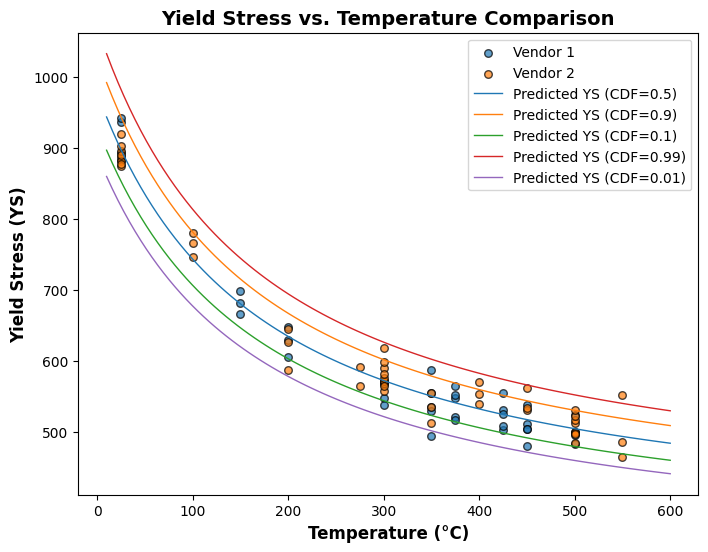

In [33]:
plot_different_cdf(gm)

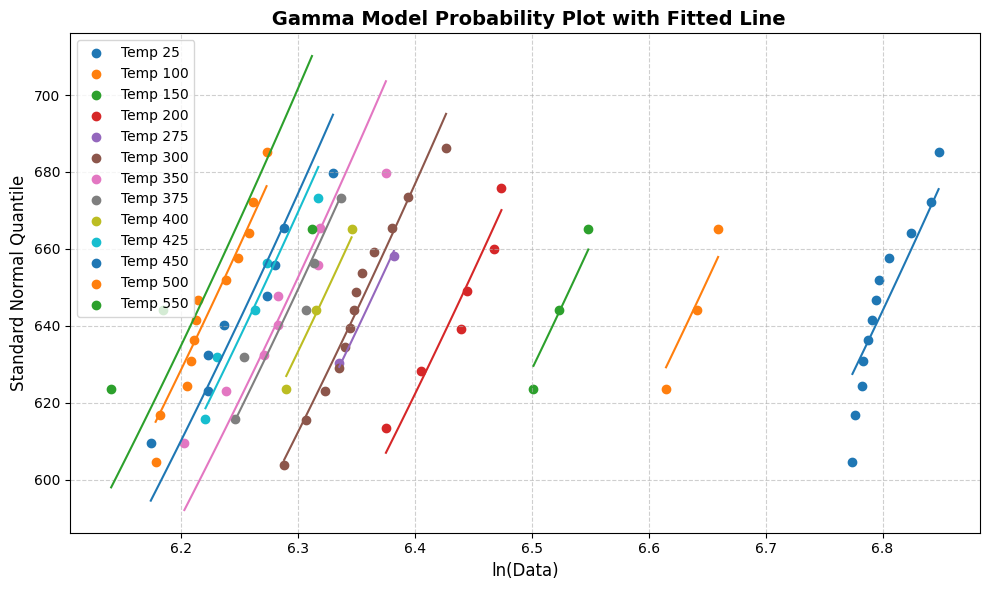

In [34]:
line_fit_plot(gm)

## Weibull (Power Law)

In [35]:
wb = WeibullModel(np.log(df['Temperature'].values), Y_values, power_law=True)

print(f"Shape: {gm.shape:.4f}") 
print(f"Intercept (u): {gm.intercept:.4f}")
print(f"Slope (w): {gm.slope:.4f}")

Shape: 644.4057
Intercept (u): -0.6071
Slope (w): 0.0241


C:\Users\mohit\AppData\Local\Temp\ipykernel_13300\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


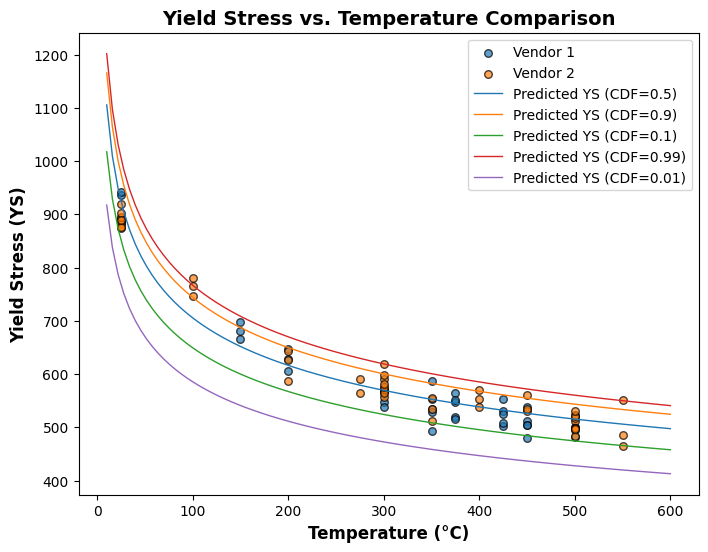

In [36]:
plot_different_cdf(wb)

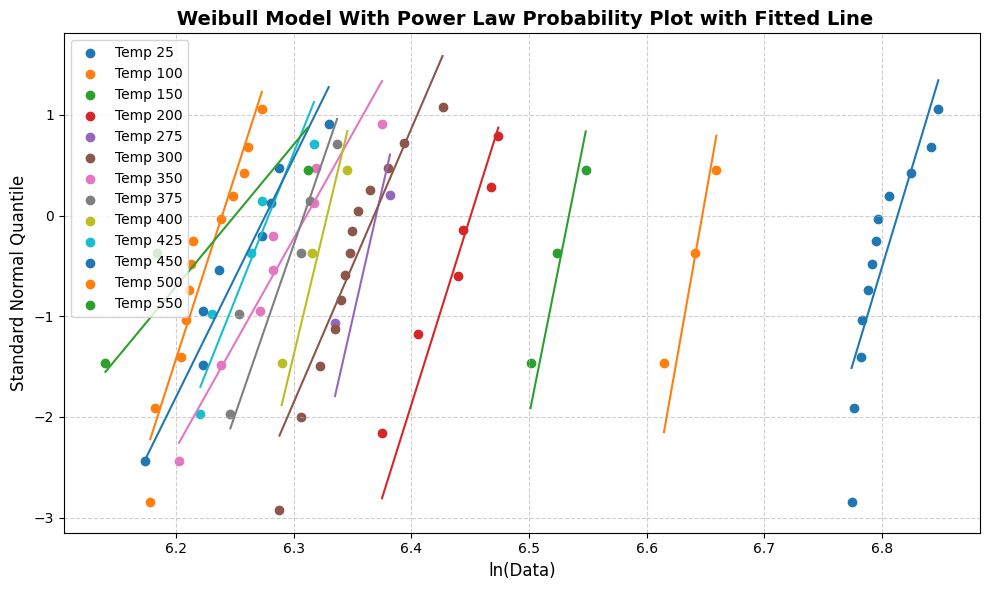

In [37]:
line_fit_plot(wb)

## Lognormal with power law

In [38]:
lm = LognormalModel(np.log(df['Temperature'].values), Y_values, power_law=True)

print(f"Sigma: {lm.sigma:.4f}") 
print(f"Intercept (k): {lm.k:.4f}")
print(f"Slope (m): {lm.m:.4f}")

Sigma: 0.0439
Intercept (k): 7.4442
Slope (m): -0.1938


C:\Users\mohit\AppData\Local\Temp\ipykernel_13300\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


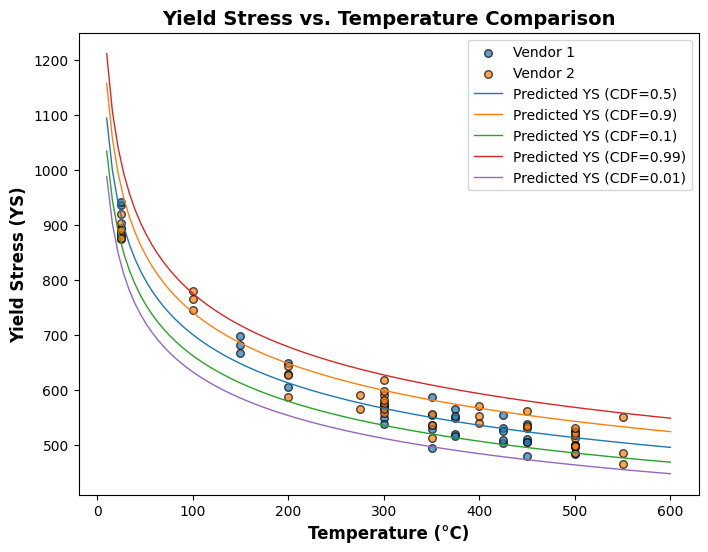

In [39]:
plot_different_cdf(lm)

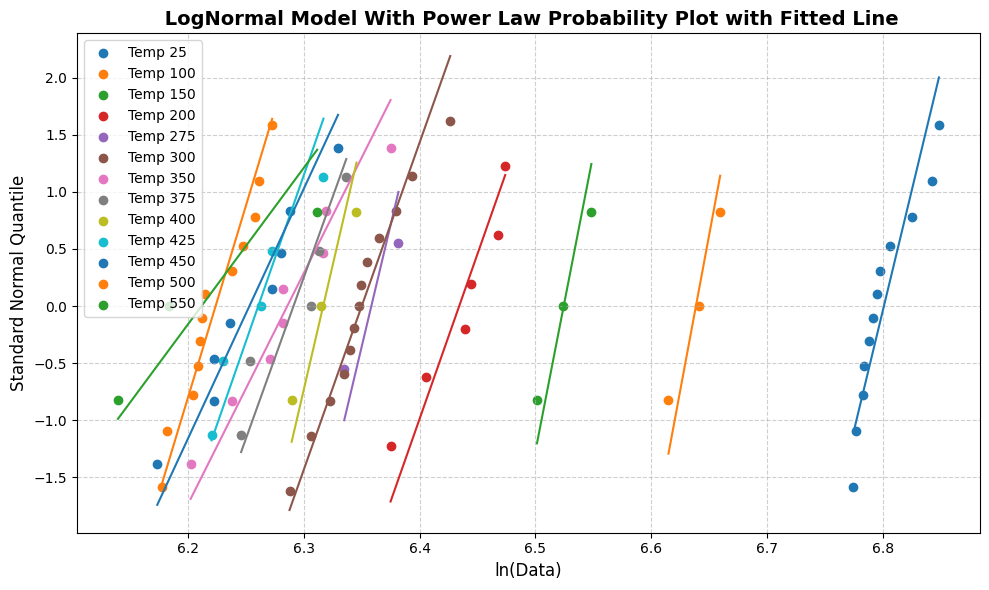

In [40]:
line_fit_plot(lm)